In [7]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

import nibabel as nib

import h5py

def get_aggprop(h5dict: h5py._hl.files.File, property: str):
    """
    Get the bundles statistics on whole brain level from the HDF5 file.

    Parameters
    ----------
    h5dict : h5py._hl.files.File 
        The opened HDF5 file.
    property : str
        The property to extract from the HDF5 file.

    Returns
    -------
    ret : np.arrasy
        The array containing the requested property values.
    """

    try:
        ret = np.array(h5dict.get("matrices").get(property))
    except:
        print("Not valid property OR h5 not opened")
    return ret

## F-tract and Probabilistic atlas comparison

Contents:
- Sanity check (not passed)
    - F-tract pairs of regions measured but with 0 probability consistent with atlas not having a bundle?

In [40]:
data_path = '/Users/mikichan/Desktop/mywork/atlas_data/'

max_delay = 50

proba_file = op.join(data_path, 'f-tract_v2112', f'F-TRACT-090624/{max_delay}/probability.txt.gz')
delay_file = op.join(data_path, 'f-tract_v2112', f'F-TRACT-090624/{max_delay}/peak_delay__median.txt')
region_file = op.join(data_path, 'f-tract_v2112', 'F-TRACT-090624/Lausanne2008-33.txt')

proba_array = np.genfromtxt(proba_file, delimiter=' ')
proba_array = np.array(proba_array).astype(float)

delay_array = np.genfromtxt(delay_file, delimiter=' ')
delay_array = np.array(delay_array).astype(float)

N = proba_array.shape[0] - 1

In [41]:
# Loading indexes
scale = 1
connFilename = op.join(data_path, f'fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5')

hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]
consistency_view = get_aggprop(hf, 'consistency')

atlas_2018_regions = gmregions_names
atlas_2018_regions = [a.decode('utf-8').lower() for a in atlas_2018_regions]

with open(region_file) as f:
    atlas_2008_regions = f.readlines()

atlas_2008_regions = [regionname.replace('.','-').lower().strip() for k, regionname in enumerate(atlas_2008_regions)]
for sidx, region in enumerate(atlas_2008_regions):
    if 'right' in region:
        atlas_2008_regions[sidx] = region.replace('right','rh')
    if 'left' in region:
        atlas_2008_regions[sidx] = region.replace('left','lh')

match_indexes = np.zeros(len(atlas_2008_regions)) - 1
for k in range(len(atlas_2008_regions)):
    for sidx, searchname in enumerate(atlas_2018_regions):
        if atlas_2008_regions[k] in searchname:
            match_indexes[k] = sidx
        if 'lh-accumbens-area' in atlas_2008_regions[k]:
            if 'lh-accumbens' in searchname:
                match_indexes[k] = sidx
        if 'rh-accumbens-area' in atlas_2008_regions[k]:
            if 'rh-accumbens' in searchname:
                match_indexes[k] = sidx
                
rightth = np.where(['thal' in tmp for tmp in atlas_2018_regions])[0][:7]
leftth = np.where(['thal' in tmp for tmp in atlas_2018_regions])[0][7:]

In [42]:
# MANUAL-MATCHING: of regions for fibers array creation
struct_conn = consistency_view / consistency_view.max()
struct_conn -= np.diag(np.diag(struct_conn))

fibers_array = np.zeros_like(proba_array)
for ridx in range(len(fibers_array)):
    for cidx in range(len(fibers_array)):
        
        if (ridx == 83) or (cidx == 83):
            fibers_array[ridx, cidx] = np.nan
        else:
            if ridx == 34 and cidx == 34: fibers_array[ridx, cidx] = struct_conn[rightth][:, rightth].mean()
            elif ridx == 34 and cidx == 75: fibers_array[ridx, cidx] = struct_conn[rightth][:, leftth].mean()
            elif ridx == 75 and cidx == 34: fibers_array[ridx, cidx] = struct_conn[leftth][:, rightth].mean()
            elif ridx == 75 and cidx == 75: fibers_array[ridx, cidx] = struct_conn[leftth][:, leftth].mean()
            else:
                fibers_array[ridx, cidx] = struct_conn[int(match_indexes[ridx]), int(match_indexes[cidx])]


fibers_array = fibers_array[:N, :N]
proba_array = proba_array[:N, :N]

In [100]:
roi_path = op.join(data_path, 'fiber_atlas/gmlabels_vol.nii')
roi_atlas, affine = nib.load(roi_path).get_fdata(), nib.load(roi_path).affine

roi_atlas2008 = np.zeros_like(roi_atlas)
for k in range(N):
    if match_indexes[k] != -1:
        roi_atlas2008[roi_atlas == (match_indexes[k]+1)] = k+1

for ridx in rightth:
    roi_atlas2008[roi_atlas == (ridx+1)] = 35

for lidx in leftth:
    roi_atlas2008[roi_atlas == (lidx+1)] = 76

In [49]:
# edges i,j of directed connectome follows rule of P_i,j/P_j,i = D_i,j/D_j,i and D_i,j + D_j,i = 1
directed_connectome = np.zeros_like(fibers_array)
for nbr in range(83):
    for nbc in range(nbr, 83):
        if fibers_array[nbr, nbc]:
            if (np.isnan(proba_array[nbr, nbc]) & np.isnan(proba_array[nbc, nbr])) or ((proba_array[nbc, nbr] == 0) & (proba_array[nbr, nbc] == 0)):
                continue
            elif np.isnan(proba_array[nbr, nbc]) or (proba_array[nbr, nbc] == 0):
                directed_connectome[nbc, nbr] = 1.0
            elif np.isnan(proba_array[nbc, nbr]) or (proba_array[nbc, nbr] == 0):
                directed_connectome[nbr, nbc] = 1.0
            else:
                directed_connectome[nbr, nbc] = 1 / (1+proba_array[nbc, nbr]/proba_array[nbr, nbc])
                directed_connectome[nbc, nbr] = 1 / (1+proba_array[nbr, nbc]/proba_array[nbc, nbr])

In [54]:
least_quantile = np.quantile(directed_connectome.flatten()[directed_connectome.flatten()!=0], 0.05) # 5% non significancy
A = (directed_connectome > least_quantile).astype(float)

print(f"Non connected nodes index: {np.where((A.sum(axis=0) + A.sum(axis=1))==0)[0][0]}")
# NOTE: Since nodes 39 seem to be non connected let's connect it using structural connectome
# A[39] = struct_conn[39] > np.quantile(struct_conn[39], 0.95)
# and we give 0.5 to one direction and 0.5 to the other

A[39] = fibers_array[39] > 0.95
A[:, 39] = fibers_array[:, 39] > 0.95

# mask_valid = np.ones(N) ; mask_valid[39] = 0
# mask_valid = mask_valid.astype(bool)
# A = A[mask_valid][:,mask_valid]

G = nx.from_numpy_array(A)
print(f"Is the graph connected - post adding edges to non connected nodes? : {nx.is_connected(G)}")

Non connected nodes index: 39
Is the graph connected - post adding edges to non connected nodes? : True


In [107]:
from src import utils
package = {'struct': A, 'atlas': nib.Nifti1Image(roi_atlas2008, affine), 'regionnames': atlas_2008_regions[:N]}
utils.save('./bin_directed_connectome_ftract+structural-d50+metadata.pkl', package)


Attempt to display on mesh

In [65]:
with open(op.join(data_path, 'lausanne2008_33-extra_data', 'region_labels.txt'), 'r') as f:
    region_labels_2008 = f.readlines()

In [77]:
with open('../../../../Desktop/regions_index.txt', "w") as f:
    for k in range(len(region_labels_2008)):
        f.write(f'{k+1};'+region_labels_2008[k])

In [133]:
# load mesh
from stl import mesh
bear_mesh = mesh.Mesh.from_file(op.join(data_path, 'lausanne2008_33-extra_data', 'lausanne_2008_meshes', 'meshL_superiorfrontal-.k8.stl'))

# f1: point1 in faces | f2: point2 in faces ...
f1 = bear_mesh.vectors[:,0,:]
f2 = bear_mesh.vectors[:,1,:]
f3 = bear_mesh.vectors[:,2,:]
nb_faces = f1.shape[0]

# associate index to each 3d point
coord2idx = {}
c = 0
f = np.concatenate([f1,f2,f3])
for k in range(nb_faces * 3):
    tmp = tuple(f[k])
    if tmp not in coord2idx:
        coord2idx[tmp] = c
        c += 1

vertices = np.array(list(coord2idx.keys()))
nb_nodes = np.array(list(coord2idx.values())).max() + 1

# bool array as flags
head_indexes = (vertices[:,1] < -6)

faces_index = []
head_coloring = []
for k in range(nb_faces):
    # convert to index the coordinate
    idx1 = coord2idx[tuple(f1[k])]
    idx2 = coord2idx[tuple(f2[k])]
    idx3 = coord2idx[tuple(f3[k])]

    faces_index.append([idx1,idx2,idx3])
    c = int(head_indexes[idx1] + head_indexes[idx2] + head_indexes[idx3])
    head_coloring.append(c)

In [134]:
vertices.min(axis=0), vertices.max(axis=0)

(array([ 6.672968 , -7.913693 ,  1.6899762], dtype=float32),
 array([23.035965, 64.39081 , 69.03007 ], dtype=float32))

In [135]:
from mpl_toolkits.mplot3d import Axes3D, art3d
def plot_mesh(vertices, f_index, f_colors, title="ZE brain", view_init=(0,-136)):
    """
    Information:
    ------------
    Plot 1 mesh given vertices and faces and faces colors

    Parameters
    ----------    
    vertices::[2darray<float>]
        Vertex positions in 3d
    f_index ::[2darray<int>]
        array of faces with faces being 3 vertices' index in vertices array
    f_colors::[1darray<float>]
        color to faces

    Returns
    -------
    None
    """

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    norm = plt.Normalize(f_colors.min(), f_colors.max())
    colors = plt.cm.viridis(norm(f_colors))

    pc = art3d.Poly3DCollection(vertices[f_index],
                                facecolors=colors)

    ax.add_collection(pc)
    ax.set_xlim(27,42)
    ax.set_ylim(-78,2)
    ax.set_zlim(-40,0)
    ax.set_title(title)
    # ax.axis('off')

    ax.view_init(view_init[0], view_init[1])
    plt.show()

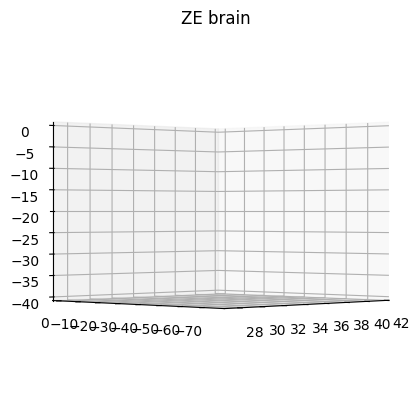

In [136]:
faces_index = np.asarray(faces_index)
head_coloring = np.asarray(head_coloring)
plot_mesh(vertices, faces_index, head_coloring)